In [13]:
!pip install pandas
!pip install joblib
!pip install scikit-learn


[notice] A new release of pip is available: 23.2.1 -> 25.3
[notice] To update, run: python3 -m pip install --upgrade pip

[notice] A new release of pip is available: 23.2.1 -> 25.3
[notice] To update, run: python3 -m pip install --upgrade pip

[notice] A new release of pip is available: 23.2.1 -> 25.3
[notice] To update, run: python3 -m pip install --upgrade pip


In [14]:
import numpy as np
from numpy import array
import pandas as pd
import matplotlib.pyplot as plt
import joblib

from keras.models import Sequential
from keras.layers import LSTM, Dense, Input

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.ensemble import IsolationForest
from sklearn.metrics import mean_absolute_error, mean_squared_error

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import LSTM, Dense, Dropout, RepeatVector, TimeDistributed, Input
from tensorflow.keras.callbacks import EarlyStopping

## Carga de los datos

In [15]:
df = pd.read_csv("datos.csv",parse_dates=['timestamp'])

print("Informacion del dataset\n")
print(df)
print(df.shape)
print(df.describe())

Informacion del dataset

               timestamp      value
0    2013-07-04 00:00:00  69.880835
1    2013-07-04 01:00:00  71.220227
2    2013-07-04 02:00:00  70.877805
3    2013-07-04 03:00:00  68.959400
4    2013-07-04 04:00:00  69.283551
...                  ...        ...
7262 2014-05-28 11:00:00  72.370206
7263 2014-05-28 12:00:00  72.172956
7264 2014-05-28 13:00:00  72.046565
7265 2014-05-28 14:00:00  71.825226
7266 2014-05-28 15:00:00  72.584089

[7267 rows x 2 columns]
(7267, 2)
                           timestamp        value
count                           7267  7267.000000
mean   2013-12-17 01:43:01.477914112    71.242433
min              2013-07-04 00:00:00    57.458406
25%              2013-10-01 13:30:00    68.369411
50%              2013-12-19 04:00:00    71.858493
75%              2014-03-06 01:30:00    74.430958
max              2014-05-28 15:00:00    86.223213
std                              NaN     4.247509


## Visualización de los datos

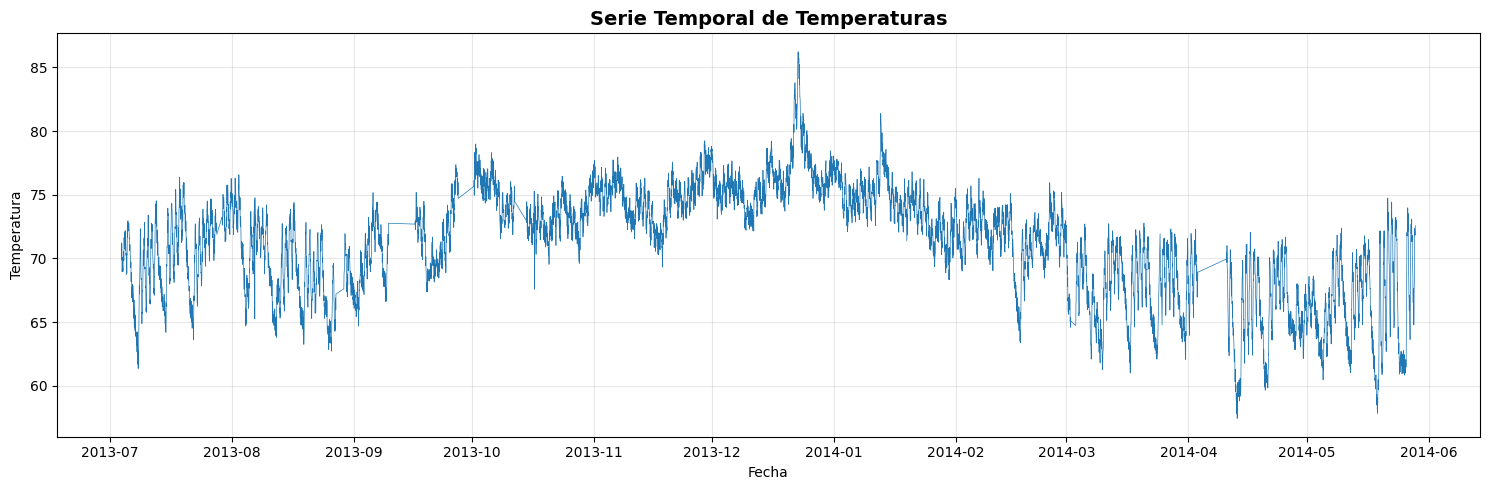

In [16]:

plt.figure(figsize=(15, 5))
plt.plot(df['timestamp'], df['value'], linewidth=0.5)
plt.title('Serie Temporal de Temperaturas', fontsize=14, fontweight='bold')
plt.xlabel('Fecha')
plt.ylabel('Temperatura')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# LSTM y detección de anomalías

## 1.a) Construcción de modelo básico

### Preparación de los datos para el entrenamiento
Vamos a construirlo con tamaño de ventana 3 y una sola feature

In [17]:
def create_sequence(data, window_size, n_features):
    windows = np.lib.stride_tricks.sliding_window_view(data, window_shape=window_size)
    X = array(windows[:-1])
    y = array(data[window_size:])
    X = X.reshape((X.shape[0], X.shape[1], n_features))
    return X, y

window_size_basic = 3
n_features = 1
raw_temp = df["value"].values
X, y = create_sequence(raw_temp, window_size_basic, n_features)
X = X.reshape((X.shape[0], X.shape[1],n_features))
print(X.shape)
print(y.shape)

(7264, 3, 1)
(7264,)


### Contrucción del modelo LSTM básico

In [18]:
def build_basic_lstm_model(window_size, lstm_units=50):
    model = Sequential([
        LSTM(lstm_units, activation='relu', input_shape=(window_size, 1)),
        Dense(1)
    ])
    
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    
    return model

model_basic = build_basic_lstm_model(window_size_basic)
model_basic.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 50)                10400     
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 10451 (40.82 KB)
Trainable params: 10451 (40.82 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


2025-11-25 19:36:58.882690: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:268] failed call to cuInit: UNKNOWN ERROR (34)


### Entrenamiento del modelo básico
Vamos a entrarlo con 30 épocas.

In [19]:
# definimoos un early stop para parar si se llega a un valor de perdida buscado
print("Entrenando modelo básico...")
history_basic = model_basic.fit(
    X, y,
    epochs=30,
    batch_size=32,
    validation_data=(X, y),
    verbose=1
)

print("Entrenamiento completado")

Entrenando modelo básico...
Epoch 1/30
227/227 [==============================] - 1s 2ms/step - loss: 672.9858 - mae: 12.5570 - val_loss: 1.1333 - val_mae: 0.8248
Epoch 2/30
227/227 [==============================] - 0s 1ms/step - loss: 1.1384 - mae: 0.8258 - val_loss: 1.1279 - val_mae: 0.8222
Epoch 3/30
227/227 [==============================] - 0s 1ms/step - loss: 1.1362 - mae: 0.8263 - val_loss: 1.1283 - val_mae: 0.8260
Epoch 4/30
227/227 [==============================] - 0s 1ms/step - loss: 1.1336 - mae: 0.8245 - val_loss: 1.1237 - val_mae: 0.8173
Epoch 5/30
227/227 [==============================] - 0s 1ms/step - loss: 1.1273 - mae: 0.8238 - val_loss: 1.1340 - val_mae: 0.8197
Epoch 6/30
227/227 [==============================] - 0s 1ms/step - loss: 1.1204 - mae: 0.8210 - val_loss: 1.1090 - val_mae: 0.8132
Epoch 7/30
227/227 [==============================] - 0s 1ms/step - loss: 1.1191 - mae: 0.8214 - val_loss: 1.0960 - val_mae: 0.8102
Epoch 8/30
227/227 [=========================

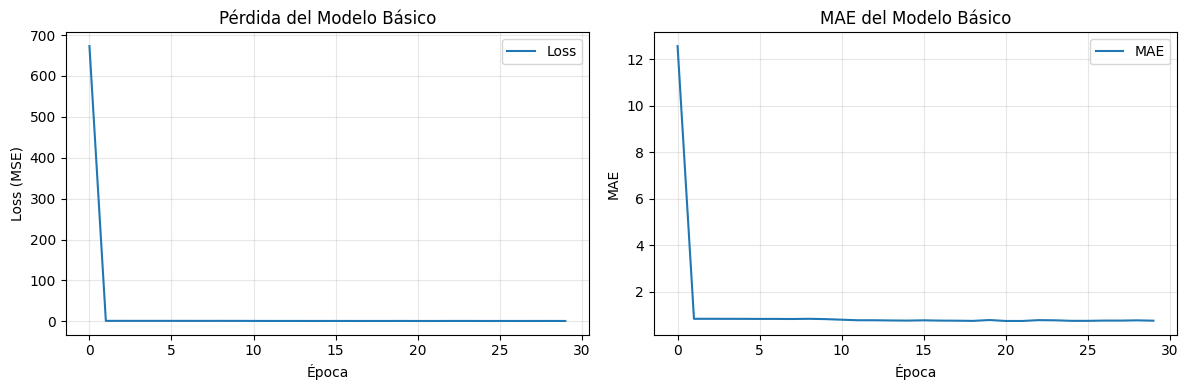

In [20]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history_basic.history['loss'], label='Loss')
plt.title('Pérdida del Modelo Básico')
plt.xlabel('Época')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(history_basic.history['mae'], label='MAE')
plt.title('MAE del Modelo Básico')
plt.xlabel('Época')
plt.ylabel('MAE')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

Podemos ver como la perdida aún no se ha estabilizado pero continuaremos con estos datos. Más adelante trataremos de mejorar el modelo. Vamos a usar como detección principal un threshold del 95 porciento por lo que el 5% de valores más alejados respecto a su valor real serán los considerados anómalos.

## 1.b) Detección de Anomalías con LSTM
Trataremos los datos como anómalos si superan el percentil 95 con mayor error respecto a su valor real.

In [21]:
def detect_anomalies_lstm(model, X, y, threshold_per=95):
    predictions = model.predict(X)
    errors = np.abs(predictions.flatten() - y)
    threshold = np.percentile(errors, threshold_per)
    anomalies = errors > threshold

    return predictions, errors, anomalies, threshold

predictions, errors, anomalies, threshold = detect_anomalies_lstm(model_basic, X, y)

anomaly_indices = np.where(anomalies)[0]
# registramos el primer valor de la ventana al contar toda ella como anómala.
anomaly_timestamps = df['timestamp'].iloc[anomaly_indices].values
anomaly_values = y[anomaly_indices]
print(f"Umbral de anomalía (percentil 95): {threshold}")

print(f"Número de anomalías detectadas: {np.sum(anomalies)}")
print(f"Porcentaje de anomalías: {100 * np.sum(anomalies) / len(anomalies):.2f}%\n")

print(f"El número de anomalias es {np.sum(anomalies)} sobre ({y.size})")
for timestamp, value in zip(anomaly_timestamps, anomaly_values):
    print(f"{timestamp} ({value})")


227/227 [==============================] - 0s 443us/step
Umbral de anomalía (percentil 95): 2.000124063249025
Número de anomalías detectadas: 364
Porcentaje de anomalías: 5.01%

El número de anomalias es 364 sobre (7264)
2013-07-04T00:00:00.000000000 (68.95939994)
2013-07-06T07:00:00.000000000 (68.19010253)
2013-07-06T09:00:00.000000000 (67.26820458)
2013-07-07T02:00:00.000000000 (64.68391715)
2013-07-08T19:00:00.000000000 (68.88572309999999)
2013-07-09T18:00:00.000000000 (69.72083178)
2013-07-10T02:00:00.000000000 (65.84066557)
2013-07-10T17:00:00.000000000 (70.48045714)
2013-07-10T18:00:00.000000000 (69.48780075)
2013-07-11T01:00:00.000000000 (66.49549932)
2013-07-11T19:00:00.000000000 (70.17998073)
2013-07-12T01:00:00.000000000 (67.43148423)
2013-07-12T17:00:00.000000000 (72.52552383)
2013-07-12T21:00:00.000000000 (71.20816904)
2013-07-13T05:00:00.000000000 (68.96127518)
2013-07-14T02:00:00.000000000 (66.62975642)
2013-07-14T22:00:00.000000000 (64.90780861)
2013-07-15T21:00:00.00000

### Visualización de las anomalías detectadas

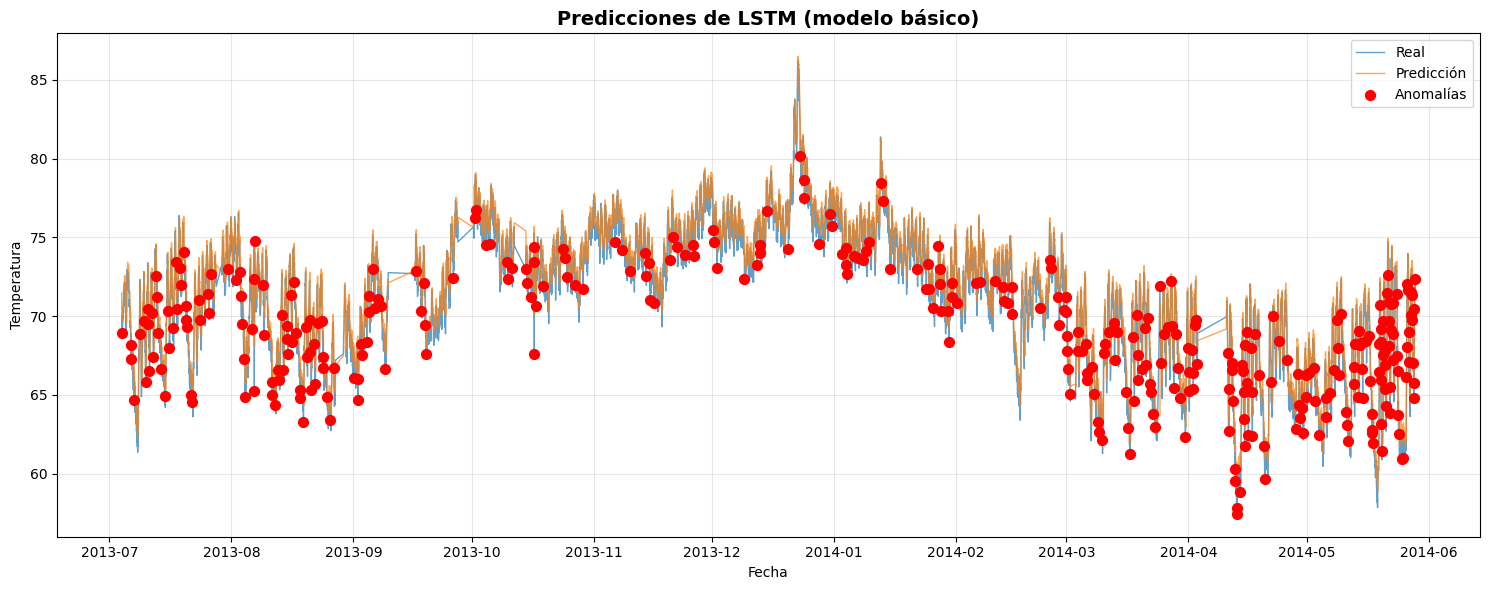

In [22]:
plt.figure(figsize=(15, 6))

timestamps = df['timestamp'].iloc[window_size_basic:].values

plt.plot(timestamps, y, label='Real', linewidth=1, alpha=0.7)
plt.plot(timestamps, predictions, label='Predicción', linewidth=1, alpha=0.7)
plt.scatter(timestamps[anomalies], y[anomalies], 
           color='red', label='Anomalías', s=50, zorder=5)

plt.title('Predicciones de LSTM (modelo básico)', fontsize=14, fontweight='bold')
plt.xlabel('Fecha')
plt.ylabel('Temperatura')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 1.c) Mejora del Modelo LSTM
Vamos a mejorar el modelo con 2 cambios.
1. Normalizaremos con MinMaxScaler consiguiendo tener los datos entre 0 y 1.
2. Añadiremos más capas, dropout y cambiaremos rango de detección además de aumentar la ventana.

In [23]:
# Normalizar los datos
window_size_improved = 24
scaler = MinMaxScaler(feature_range=(0, 1))
values_scaled = scaler.fit_transform(raw_temp.reshape(-1, 1)).flatten()

# Crear secuencias con datos normalizados
X_scaled, y_scaled = create_sequence(values_scaled, window_size_improved,n_features)

X_scaled = X_scaled.reshape((X_scaled.shape[0], X_scaled.shape[1],n_features))


print("Datos normalizados con MinMaxScaler")
print(f"Rango original: [{raw_temp.min():.2f}, {raw_temp.max():.2f}]")
print(f"Rango escalado: [{values_scaled.min():.2f}, {values_scaled.max():.2f}]")

Datos normalizados con MinMaxScaler
Rango original: [57.46, 86.22]
Rango escalado: [0.00, 1.00]


In [24]:
def build_improved_lstm_model(window_size):
    model = Sequential([
        LSTM(100, activation='relu', return_sequences=True, input_shape=(window_size, 1)),
        Dropout(0.2),
        LSTM(50, activation='relu'),
        Dropout(0.2),
        Dense(25, activation='relu'),
        Dense(1)
    ])
    
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    
    return model
    
model_improved = build_improved_lstm_model(window_size_improved)

print("Arquitectura del Modelo LSTM Mejorado:")
model_improved.summary()

Arquitectura del Modelo LSTM Mejorado:
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 24, 100)           40800     
                                                                 
 dropout (Dropout)           (None, 24, 100)           0         
                                                                 
 lstm_2 (LSTM)               (None, 50)                30200     
                                                                 
 dropout_1 (Dropout)         (None, 50)                0         
                                                                 
 dense_1 (Dense)             (None, 25)                1275      
                                                                 
 dense_2 (Dense)             (None, 1)                 26        
                                                                 
Total params: 7

In [25]:
print("Entrenando modelo LSTM mejorado...")
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history_improved = model_improved.fit(
    X_scaled, y_scaled,
    epochs=50,
    batch_size=32,
    validation_data=(X_scaled, y_scaled),
    callbacks=[early_stop],
    verbose=1
)

print("\nEntrenamiento completado")

Entrenando modelo LSTM mejorado...
Epoch 1/50
227/227 [==============================] - 3s 9ms/step - loss: 0.0151 - mae: 0.0844 - val_loss: 0.0046 - val_mae: 0.0539
Epoch 2/50
227/227 [==============================] - 2s 8ms/step - loss: 0.0052 - mae: 0.0579 - val_loss: 0.0048 - val_mae: 0.0569
Epoch 3/50
227/227 [==============================] - 2s 8ms/step - loss: 0.0034 - mae: 0.0458 - val_loss: 0.0019 - val_mae: 0.0343
Epoch 4/50
227/227 [==============================] - 2s 8ms/step - loss: 0.0025 - mae: 0.0389 - val_loss: 0.0021 - val_mae: 0.0365
Epoch 5/50
227/227 [==============================] - 2s 8ms/step - loss: 0.0020 - mae: 0.0353 - val_loss: 0.0015 - val_mae: 0.0306
Epoch 6/50
227/227 [==============================] - 2s 8ms/step - loss: 0.0019 - mae: 0.0337 - val_loss: 0.0017 - val_mae: 0.0326
Epoch 7/50
227/227 [==============================] - 2s 8ms/step - loss: 0.0017 - mae: 0.0324 - val_loss: 0.0017 - val_mae: 0.0334
Epoch 8/50
227/227 [=====================

In [26]:
predictions_improved, errors_improved, anomalies_improved, threshold_improved = detect_anomalies_lstm(
    model_improved, X_scaled, y_scaled, threshold_per=98
)

227/227 [==============================] - 1s 2ms/step


In [27]:
# Denormalizamos de nuevo los datos para poder analizarlos.
y_improved_denorm = scaler.inverse_transform(y_scaled.reshape(-1, 1)).flatten()
predictions_improved_denorm = scaler.inverse_transform(predictions_improved.reshape(-1, 1)).flatten()
errors_improved_denorm = np.abs(predictions_improved_denorm - y_improved_denorm)
threshold_improved_denorm = np.percentile(errors_improved_denorm, 98)

anomaly_indices_improved = np.where(anomalies_improved)[0]
anomaly_timestamps_improved = df['timestamp'].iloc[anomaly_indices_improved].values
anomaly_values_improved = y_improved_denorm[anomaly_indices_improved]

In [28]:
print(f"Umbral de anomalía (percentil 98): {threshold_improved_denorm:.2f}")
print(f"Número de anomalías detectadas: {np.sum(anomalies_improved)}")
print(f"Porcentaje de anomalías: {100 * np.sum(anomalies_improved) / len(anomalies_improved):.2f}%\n")
print(f"El número de anomalias es {np.sum(anomalies_improved)} sobre ({y_improved_denorm.size})")
for timestamp, value in zip(anomaly_timestamps_improved, anomaly_values_improved):
    print(f"{timestamp} ({value:.2f})")

Umbral de anomalía (percentil 98): 2.57
Número de anomalías detectadas: 145
Porcentaje de anomalías: 2.00%

El número de anomalias es 145 sobre (7243)
2013-07-04T11:00:00.000000000 (72.53)
2013-07-07T18:00:00.000000000 (72.34)
2013-07-14T16:00:00.000000000 (72.97)
2013-07-14T18:00:00.000000000 (73.95)
2013-07-17T18:00:00.000000000 (76.39)
2013-07-18T14:00:00.000000000 (75.33)
2013-07-19T12:00:00.000000000 (69.75)
2013-07-21T09:00:00.000000000 (67.07)
2013-08-03T11:00:00.000000000 (64.86)
2013-08-03T13:00:00.000000000 (64.70)
2013-08-05T20:00:00.000000000 (65.26)
2013-08-18T12:00:00.000000000 (68.10)
2013-08-23T13:00:00.000000000 (65.30)
2013-09-09T04:00:00.000000000 (74.72)
2013-09-09T05:00:00.000000000 (75.18)
2013-09-22T13:00:00.000000000 (72.71)
2013-09-22T14:00:00.000000000 (72.85)
2013-09-24T18:00:00.000000000 (75.85)
2013-09-26T18:00:00.000000000 (78.19)
2013-09-26T19:00:00.000000000 (78.34)
2013-09-27T00:00:00.000000000 (78.99)
2013-10-03T12:00:00.000000000 (76.25)
2013-10-03T13

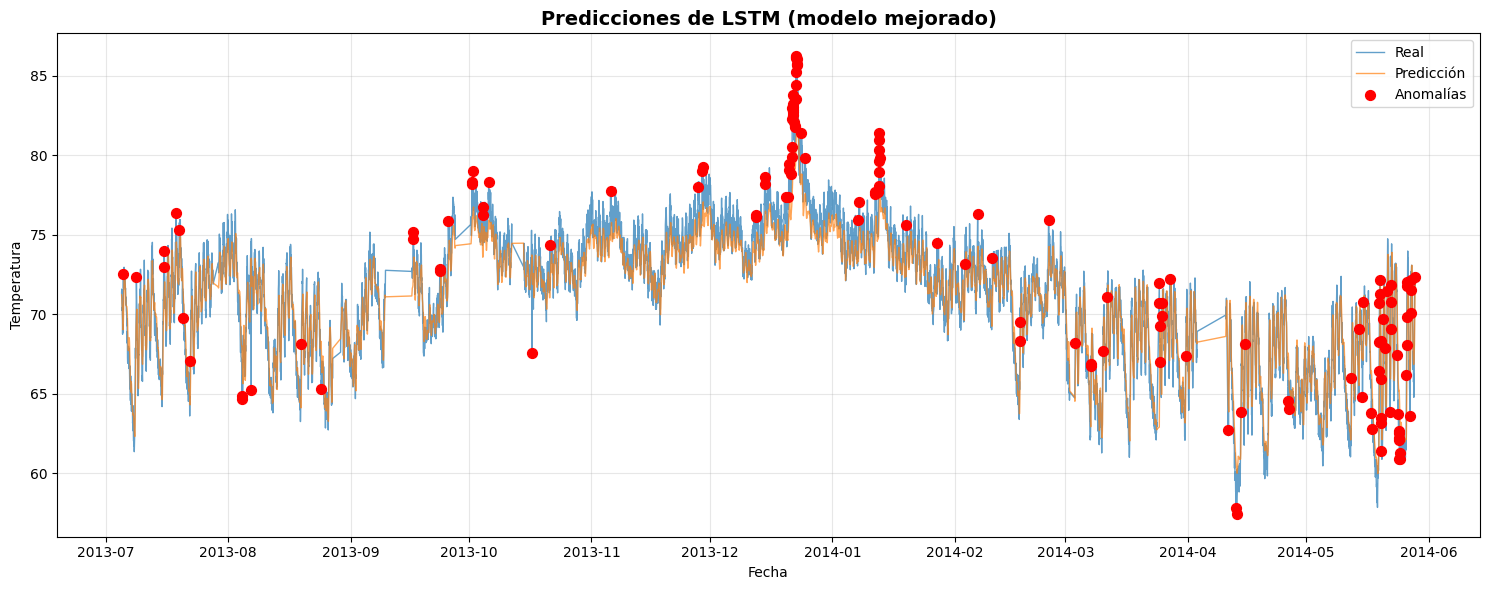

['scaler.pkl']

In [29]:
plt.figure(figsize=(15, 6))
timestamps_improved = df['timestamp'].iloc[window_size_improved:].values
plt.plot(timestamps_improved, y_improved_denorm, label='Real', linewidth=1, alpha=0.7)
plt.plot(timestamps_improved, predictions_improved_denorm, label='Predicción', linewidth=1, alpha=0.7)
plt.scatter(timestamps_improved[anomalies_improved], y_improved_denorm[anomalies_improved], 
           color='red', label='Anomalías', s=50, zorder=5)
plt.title('Predicciones de LSTM (modelo mejorado)', fontsize=14, fontweight='bold')
plt.xlabel('Fecha')
plt.ylabel('Temperatura')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()
model_improved.save("model.keras")
joblib.dump(scaler, "scaler.pkl")

En este caso he decidido subir al percentil 98 para limitar aún más los valores de las anomalías ya que asumo que la tasa de error del dispositivo no puede llegar al 5% de las muestras. De esta forma nos quedamos con las 145 mediciones con diferencia mayor respecto a su valor real.

### Comparación de los resultados

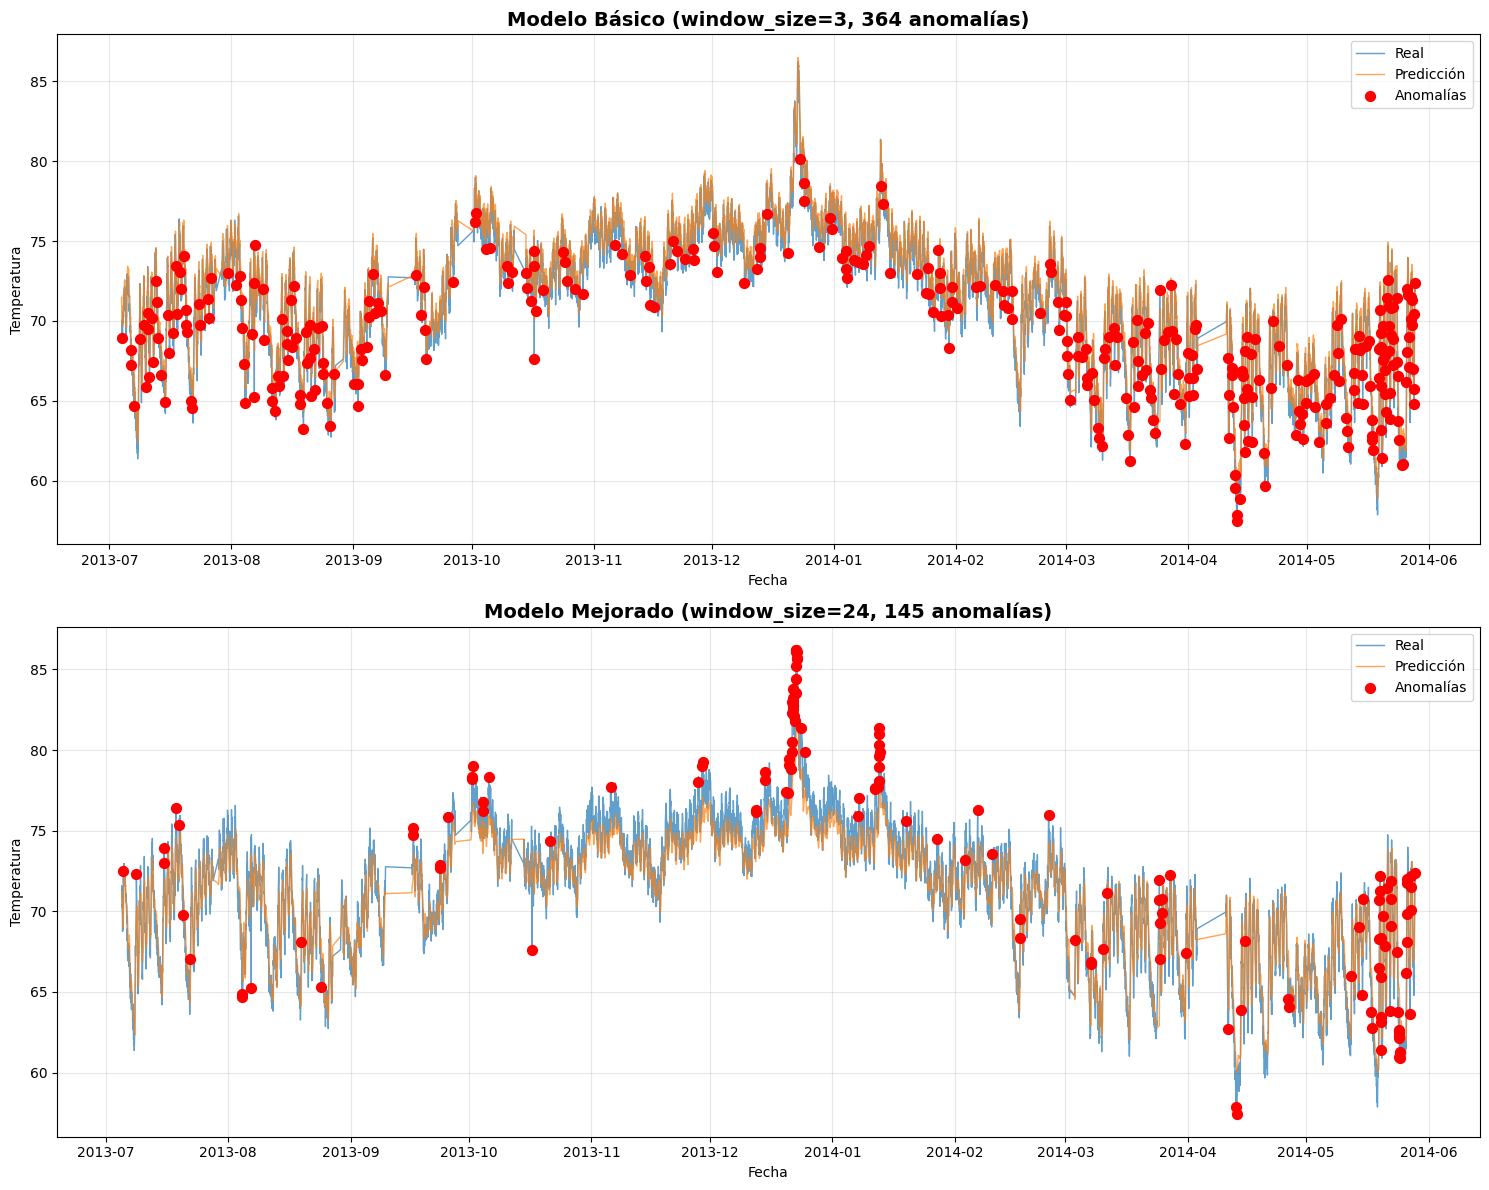

In [30]:
plt.figure(figsize=(15, 12))

plt.subplot(2, 1, 1)
timestamps_basic = df['timestamp'].iloc[window_size_basic:].values
plt.plot(timestamps_basic, y, label='Real', linewidth=1, alpha=0.7)
plt.plot(timestamps_basic, predictions, label='Predicción', linewidth=1, alpha=0.7)
plt.scatter(timestamps_basic[anomalies], y[anomalies], color='red', label='Anomalías', s=50, zorder=5)
plt.title(f'Modelo Básico (window_size={window_size_basic}, {np.sum(anomalies)} anomalías)', fontsize=14, fontweight='bold')
plt.xlabel('Fecha')
plt.ylabel('Temperatura')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(2, 1, 2)
timestamps_improved = df['timestamp'].iloc[window_size_improved:].values
plt.plot(timestamps_improved, y_improved_denorm, label='Real', linewidth=1, alpha=0.7)
plt.plot(timestamps_improved, predictions_improved_denorm, label='Predicción', linewidth=1, alpha=0.7)
plt.scatter(timestamps_improved[anomalies_improved], y_improved_denorm[anomalies_improved], color='red', label='Anomalías', s=50, zorder=5)
plt.title(f'Modelo Mejorado (window_size={window_size_improved}, {np.sum(anomalies_improved)} anomalías)', fontsize=14, fontweight='bold')
plt.xlabel('Fecha')
plt.ylabel('Temperatura')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

Se valida con los propios datos con los que se entrena algo que no tiene mucho sentido pero bueno, al tratarse de una practica, es suficiente para llegar a algunas conclusiones

In [31]:
print("COMPARACIÓN DE RESULTADOS")

print("\nModelo Básico:")
print(f"   - Anomalías detectadas: {np.sum(anomalies)}")
print(f"   - MAE en validación: {history_basic.history['val_mae'][-1]:.4f}")
print(f"   - MSE en validación: {history_basic.history['val_loss'][-1]:.4f}")

print("\nModelo Mejorado (con normalización + arquitectura compleja):")
print(f"   - Anomalías detectadas: {np.sum(anomalies_improved)}")
print(f"   - MAE en validación: {history_improved.history['val_mae'][-1]:.4f}")
print(f"   - MSE en validación: {history_improved.history['val_loss'][-1]:.4f}")

print("\nMejoras aplicadas:")
print("   1. Normalización MinMaxScaler (rango [0,1])")
print("   2. Arquitectura con 2 capas LSTM + Dropout")
print("   3. Mayor número de unidades (100 y 50)")

# Calcular mejora porcentual
mae_improvement = ((history_basic.history['val_mae'][-1] - history_improved.history['val_mae'][-1]) 
                   / history_basic.history['val_mae'][-1] * 100)
print(f"\nMejora en MAE: {mae_improvement:.2f}%")

COMPARACIÓN DE RESULTADOS

Modelo Básico:
   - Anomalías detectadas: 364
   - MAE en validación: 0.8564
   - MSE en validación: 1.1340

Modelo Mejorado (con normalización + arquitectura compleja):
   - Anomalías detectadas: 145
   - MAE en validación: 0.0338
   - MSE en validación: 0.0017

Mejoras aplicadas:
   1. Normalización MinMaxScaler (rango [0,1])
   2. Arquitectura con 2 capas LSTM + Dropout
   3. Mayor número de unidades (100 y 50)

Mejora en MAE: 96.05%


# Autoencoder para detección de anomalías

In [32]:
window_size_autoencoder = 24
def build_autoencoder(window_size):
    inputs = Input(shape=(window_size, 1))
    encoded = LSTM(64, activation='relu', return_sequences=True)(inputs)
    encoded = LSTM(32, activation='relu', return_sequences=False)(encoded)
    
    decoded = RepeatVector(window_size)(encoded)
    decoded = LSTM(32, activation='relu', return_sequences=True)(decoded)
    decoded = LSTM(64, activation='relu', return_sequences=True)(decoded)
    decoded = TimeDistributed(Dense(1))(decoded)
    
    autoencoder = Model(inputs, decoded)
    autoencoder.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mse')
    # sin el optimizer al entrenar el modelo daba unos loss muy grandes.
    
    return autoencoder

autoencoder = build_autoencoder(window_size_autoencoder)
print("Arquitectura del Autoencoder:")
autoencoder.summary()

Arquitectura del Autoencoder:
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 24, 1)]           0         
                                                                 
 lstm_3 (LSTM)               (None, 24, 64)            16896     
                                                                 
 lstm_4 (LSTM)               (None, 32)                12416     
                                                                 
 repeat_vector (RepeatVecto  (None, 24, 32)            0         
 r)                                                              
                                                                 
 lstm_5 (LSTM)               (None, 24, 32)            8320      
                                                                 
 lstm_6 (LSTM)               (None, 24, 64)            24832     
                               

In [33]:
X_autoencoder, _ = create_sequence(raw_temp, window_size_autoencoder, n_features)

### Entrenamiento del autoencoder

In [ ]:
print("Entrenando autoencoder...")
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history_autoencoder = autoencoder.fit(
    X_autoencoder, X_autoencoder,
    epochs=50,
    batch_size=32,
    validation_data=(X_autoencoder, X_autoencoder),
    callbacks=[early_stop],
    verbose=1
)
print("Entrenamiento completado")

Entrenando autoencoder...
Epoch 1/50
227/227 [==============================] - 4s 12ms/step - loss: 13215.9609 - val_loss: 3235.7793
Epoch 2/50
227/227 [==============================] - 3s 11ms/step - loss: 2676.0884 - val_loss: 2390.7754
Epoch 3/50
227/227 [==============================] - 3s 11ms/step - loss: 2492.0366 - val_loss: 1416.9327
Epoch 4/50
227/227 [==============================] - 3s 11ms/step - loss: 1113.5406 - val_loss: 943.8425
Epoch 5/50
227/227 [==============================] - 3s 11ms/step - loss: 851.4606 - val_loss: 835.0402
Epoch 6/50
227/227 [==============================] - 3s 11ms/step - loss: 841.3372 - val_loss: 717.5599
Epoch 7/50
227/227 [==============================] - 3s 11ms/step - loss: 664.0991 - val_loss: 616.2334
Epoch 8/50
227/227 [==============================] - 3s 11ms/step - loss: 574.4347 - val_loss: 516.7944
Epoch 9/50
227/227 [==============================] - 3s 11ms/step - loss: 473.8591 - val_loss: 445.6781
Epoch 10/50
227/227 [

Volvemos a trabajar con el percentil 95 y analizaremos los datos para compararlo con el modelo basico

In [ ]:
reconstructed = autoencoder.predict(X_autoencoder)
reconstruction_errors = np.mean(np.abs(X_autoencoder - reconstructed), axis=(1, 2))
threshold_autoencoder = np.percentile(reconstruction_errors, 95)
anomalies_autoencoder = reconstruction_errors > threshold_autoencoder

print(f"Umbral de anomalía (percentil 98): {threshold_autoencoder:.4f}")
print(f"Número de anomalías detectadas: {np.sum(anomalies_autoencoder)}")
print(f"Porcentaje de anomalías: {100 * np.sum(anomalies_autoencoder) / len(anomalies_autoencoder):.2f}%\n")

anomaly_indices_autoencoder = np.where(anomalies_autoencoder)[0]
anomaly_timestamps_autoencoder = df['timestamp'].iloc[anomaly_indices_autoencoder].values
anomaly_values_autoencoder = raw_temp[window_size_autoencoder:][anomaly_indices_autoencoder]

print(f"El número de anomalias es {np.sum(anomalies_autoencoder)} sobre ({len(anomalies_autoencoder)})")
for timestamp, value in zip(anomaly_timestamps_autoencoder, anomaly_values_autoencoder):
    print(f"{timestamp} ({value:.2f})")

In [ ]:
plt.figure(figsize=(15, 6))
timestamps_autoencoder = df['timestamp'].iloc[window_size_autoencoder:].values
values_autoencoder = raw_temp[window_size_autoencoder:]
plt.plot(timestamps_autoencoder, values_autoencoder, label='Real', linewidth=1, alpha=0.7)
plt.scatter(timestamps_autoencoder[anomalies_autoencoder], values_autoencoder[anomalies_autoencoder], 
           color='red', label='Anomalías', s=50, zorder=5)
plt.title('Detección de Anomalías con Autoencoder', fontsize=14, fontweight='bold')
plt.xlabel('Fecha')
plt.ylabel('Temperatura')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

mae_autoencoder = np.mean(reconstruction_errors)
mse_autoencoder = np.mean(reconstruction_errors**2)
rmse_autoencoder = np.sqrt(mse_autoencoder)

print("\nMÉTRICAS AUTOENCODER")
print(f"  MAE (Error Reconstrucción):  {mae_autoencoder:.4f}")
print(f"  MSE (Error Reconstrucción):  {mse_autoencoder:.4f}")
print(f"  RMSE (Error Reconstrucción): {rmse_autoencoder:.4f}")

# Isolation forest para detección de anomalías

### Preparación de los datos

In [ ]:
X_isolation = X_autoencoder.reshape(X_autoencoder.shape[0], -1)

### Entrenamiento del modelo

In [ ]:
iso_forest = IsolationForest(contamination=0.05, random_state=42)
predictions_isolation = iso_forest.fit_predict(X_isolation)
anomalies_isolation = predictions_isolation == -1

### Análisis de los datos

In [ ]:
print(f"Número de anomalías detectadas: {np.sum(anomalies_isolation)}")
print(f"Porcentaje de anomalías: {100 * np.sum(anomalies_isolation) / len(anomalies_isolation):.2f}%\n")

anomaly_indices_isolation = np.where(anomalies_isolation)[0]
anomaly_timestamps_isolation = df['timestamp'].iloc[anomaly_indices_isolation].values
anomaly_values_isolation = raw_temp[window_size_autoencoder:][anomaly_indices_isolation]

print(f"El número de anomalias es {np.sum(anomalies_isolation)} sobre ({len(anomalies_isolation)})")
for timestamp, value in zip(anomaly_timestamps_isolation, anomaly_values_isolation):
    print(f"{timestamp} ({value:.2f})")

In [ ]:
plt.figure(figsize=(15, 6))
timestamps_isolation = df['timestamp'].iloc[window_size_autoencoder:].values
values_isolation = raw_temp[window_size_autoencoder:]
plt.plot(timestamps_isolation, values_isolation, label='Real', linewidth=1, alpha=0.7)
plt.scatter(timestamps_isolation[anomalies_isolation], values_isolation[anomalies_isolation], 
           color='red', label='Anomalías', s=50, zorder=5)
plt.title('Detección de Anomalías con Isolation Forest', fontsize=14, fontweight='bold')
plt.xlabel('Fecha')
plt.ylabel('Temperatura')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## Comparativa final

In [ ]:
plt.figure(figsize=(15, 16))

plt.subplot(3, 1, 1)
timestamps_improved = df['timestamp'].iloc[window_size_improved:].values
plt.plot(timestamps_improved, y_improved_denorm, label='Real', linewidth=1, alpha=0.7)
plt.plot(timestamps_improved, predictions_improved_denorm, label='Predicción', linewidth=1, alpha=0.7)
plt.scatter(timestamps_improved[anomalies_improved], y_improved_denorm[anomalies_improved], 
           color='red', label='Anomalías', s=50, zorder=5)
plt.title(f'Modelo LSTM Mejorado (window_size={window_size_improved}, {np.sum(anomalies_improved)} anomalías)', 
         fontsize=14, fontweight='bold')
plt.xlabel('Fecha')
plt.ylabel('Temperatura')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(3, 1, 2)
timestamps_autoencoder = df['timestamp'].iloc[window_size_autoencoder:].values
values_autoencoder = raw_temp[window_size_autoencoder:]
plt.plot(timestamps_autoencoder, values_autoencoder, label='Real', linewidth=1, alpha=0.7)
plt.scatter(timestamps_autoencoder[anomalies_autoencoder], values_autoencoder[anomalies_autoencoder], 
           color='red', label='Anomalías', s=50, zorder=5)
plt.title(f'Autoencoder (window_size={window_size_autoencoder}, {np.sum(anomalies_autoencoder)} anomalías)', 
         fontsize=14, fontweight='bold')
plt.xlabel('Fecha')
plt.ylabel('Temperatura')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(3, 1, 3)
timestamps_isolation = df['timestamp'].iloc[window_size_autoencoder:].values
values_isolation = raw_temp[window_size_autoencoder:]
plt.plot(timestamps_isolation, values_isolation, label='Real', linewidth=1, alpha=0.7)
plt.scatter(timestamps_isolation[anomalies_isolation], values_isolation[anomalies_isolation], 
           color='red', label='Anomalías', s=50, zorder=5)
plt.title(f'Isolation Forest (window_size={window_size_autoencoder}, {np.sum(anomalies_isolation)} anomalías)', 
         fontsize=14, fontweight='bold')
plt.xlabel('Fecha')
plt.ylabel('Temperatura')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()